Classification Accuracies:
Num Components Train Accuracy  Validation Accuracy Test Accuracy  
2          93.47           89.50               92.50          
4          99.05           99.16               100.00         
16         100.00          100.00              100.00         
32         100.00          100.00              100.00         


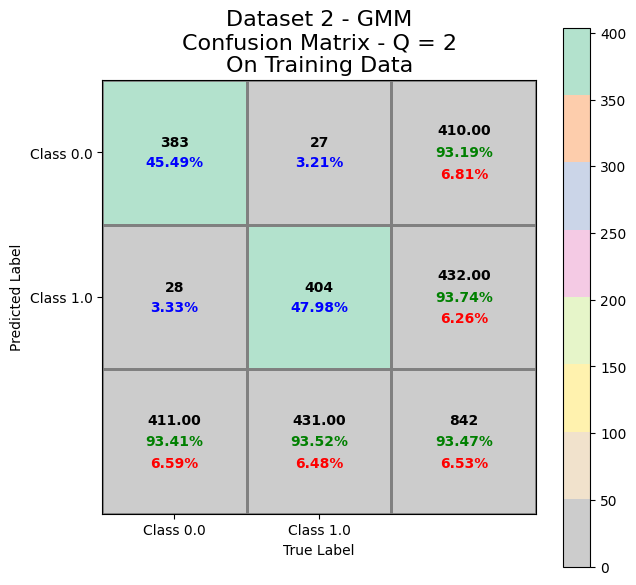

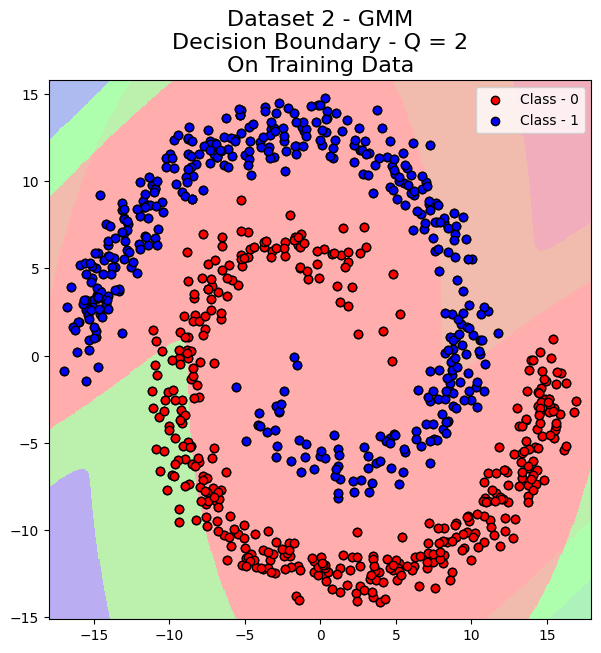

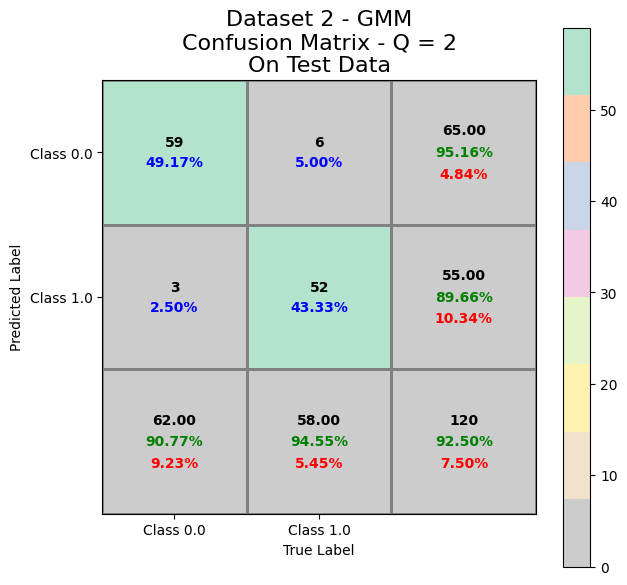

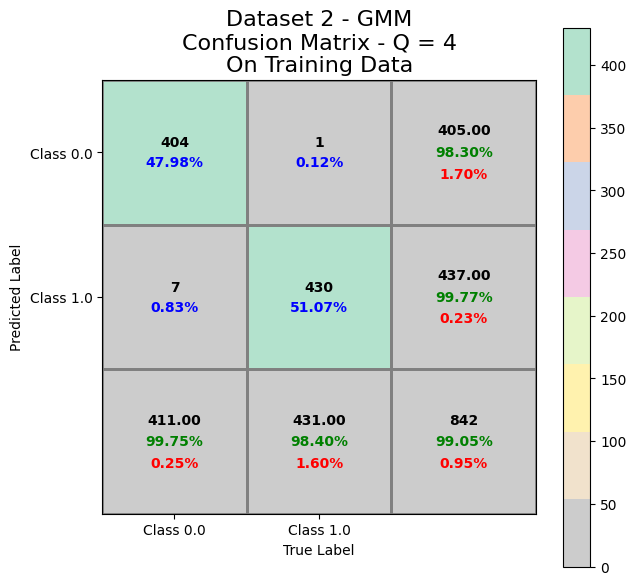

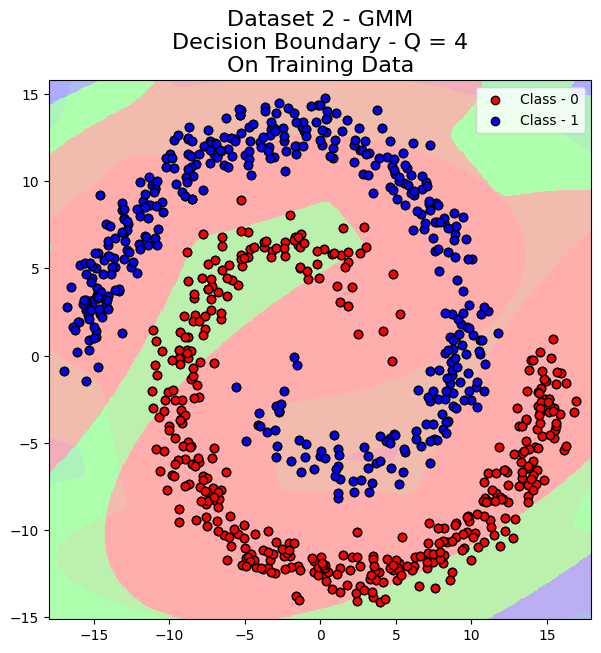

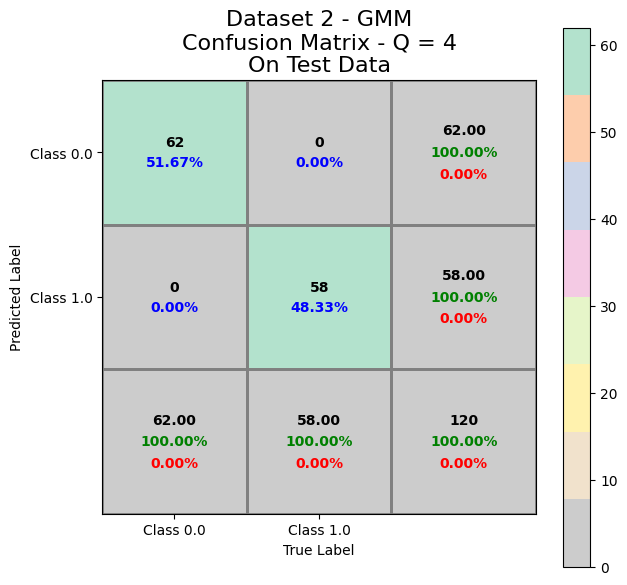

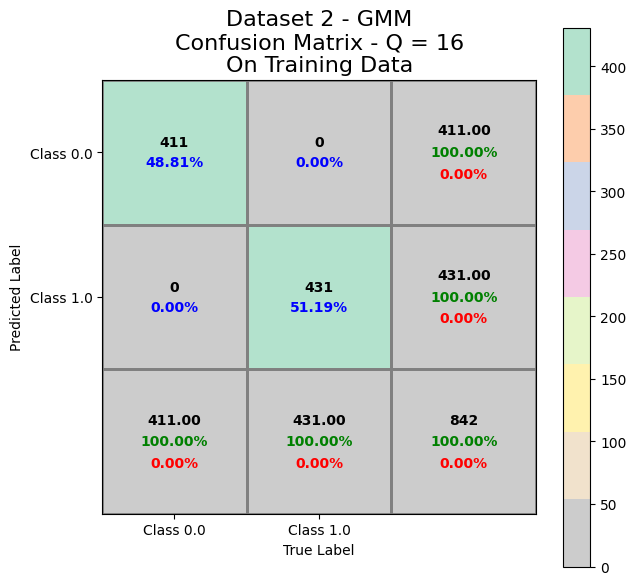

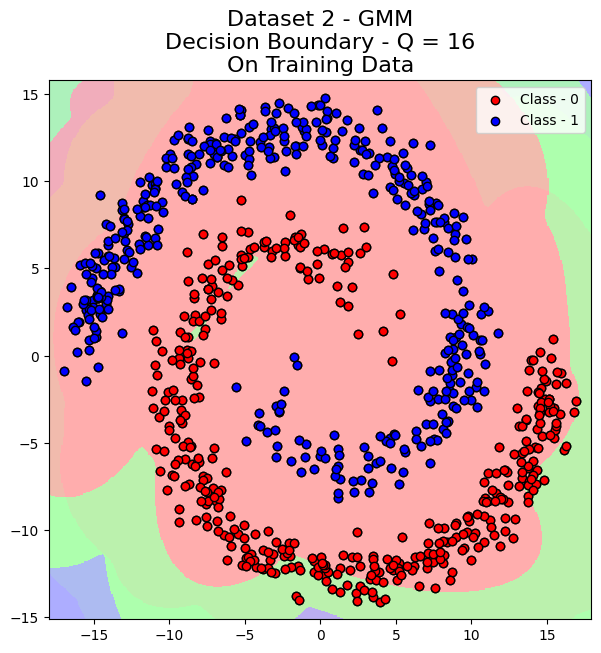

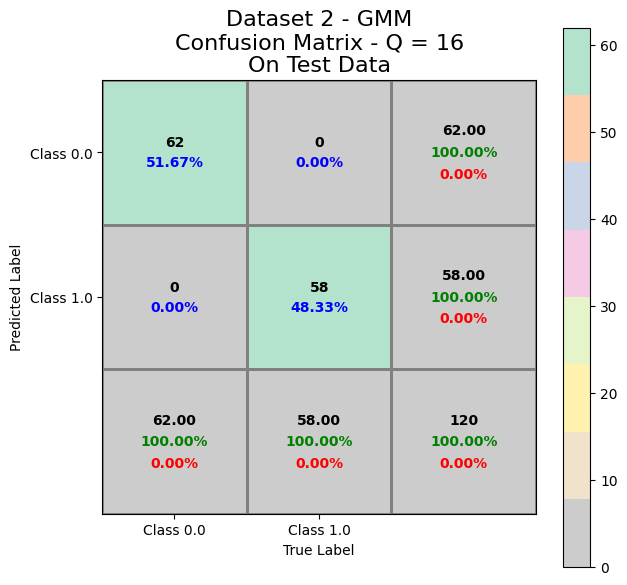

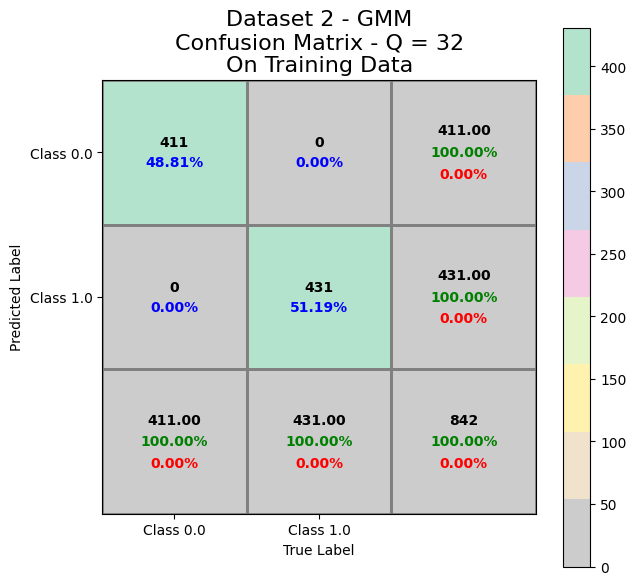

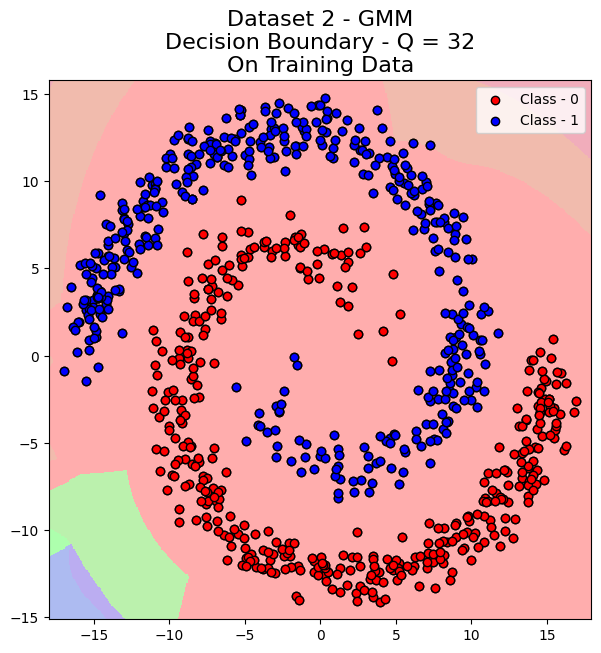

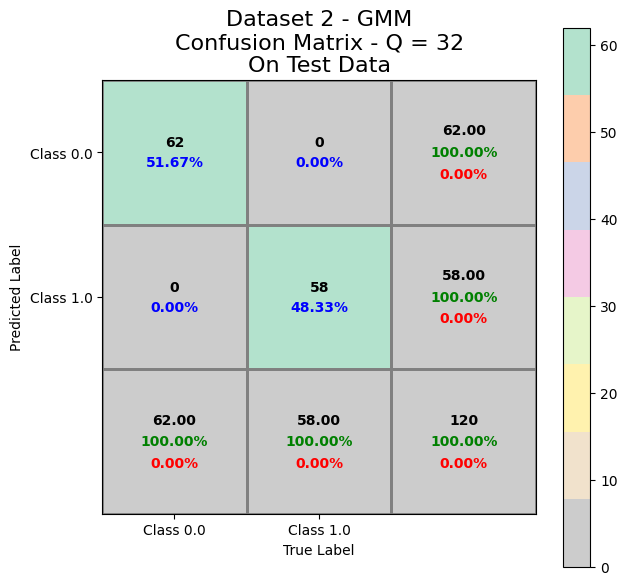

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from scipy import linalg
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap


def build_and_train_model(num_components, class_x):
    model = GaussianMixture(n_components=num_components, covariance_type='full', max_iter=100)

    model.fit(class_x)

    return model

def evaluate_model(model, X, y):
    y_pred = model.predict(X)

    accuracy = np.mean(y_pred == y)*100

    accuracy2 = accuracy_score(y, y_pred)

    return accuracy, accuracy2, y_pred

def confusion_matrix(y_true, y_pred, accuracy, labels=None):
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    num_labels = len(labels)
    cm = np.zeros((num_labels + 1, num_labels + 1), float)
    label_to_index = {label: i for i, label in enumerate(labels)}
    true_positives = np.zeros(num_labels)
    pred_positives = np.zeros(num_labels)
    total_samples = len(y_true)
    for true, pred in zip(y_true, y_pred):
        true_index = label_to_index[true]
        pred_index = label_to_index[pred]
        cm[true_index, pred_index] += 1
        true_positives[true_index] += 1 if true == pred else 0
        pred_positives[pred_index] += 1 if true == pred else 0
    cm = cm.T
    accuracy = np.sum(np.diag(cm)) / total_samples
    cm[-1, :-1] = (true_positives / np.sum(cm[:-1, :-1], axis=1)) * 100
    cm[:-1, -1] = (pred_positives / np.sum(cm[:-1, :-1], axis=0)) * 100
    cm[-1, -1] = accuracy * 100
    return cm

def plot_confusion_matrix(y_true, y_pred, accuracy, title):
    cm = confusion_matrix(y_true, y_pred, accuracy)
    cm_backup = confusion_matrix(y_true, y_pred, accuracy)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == cm.shape[0] - 1 or j == cm.shape[1] - 1:
                cm[i, j] = 0.0
    number_of_classes = len(np.unique(y_true))
    plt.figure(figsize=(number_of_classes + 5, number_of_classes + 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Pastel2_r)
    cm = cm_backup
    plt.title(title, fontsize=16)
    plt.colorbar()
    labels = []
    for i in np.unique(y_true):
        label = "Class " + str(i)
        labels.append(label)
    plt.xticks(range(len(np.unique(y_true))), labels=labels)
    plt.yticks(range(len(np.unique(y_true))), labels=labels)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

    cm_except_last_row_col = cm[:-1, :-1]
    cm_row_sum = np.sum(cm_except_last_row_col, axis=1)
    cm_col_sum = np.sum(cm_except_last_row_col, axis=0)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        row_sum = 0
        for j in range(cm.shape[1]):
            if i == cm.shape[0] - 1 and j == cm.shape[1] - 1:
                plt.text(
                    j,
                    i - 0.15,
                    format(y_true.size, "d"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i,
                    format(cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="green",
                )
                plt.text(
                    j,
                    i + 0.15,
                    format(100 - cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="red",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)
            elif j == cm.shape[1] - 1:
                plt.text(
                    j,
                    i - 0.15,
                    format(cm_row_sum[i], ".2f"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i,
                    format(cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="green",
                )
                plt.text(
                    j,
                    i + 0.15,
                    format(100 - cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="red",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)
            elif i == cm.shape[0] - 1:
                plt.text(
                    j,
                    i - 0.15,
                    format(cm_col_sum[j], ".2f"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i,
                    format(cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="green",
                )
                plt.text(
                    j,
                    i + 0.15,
                    format(100 - cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="red",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)
            else:
                percent = (cm[i, j] / y_true.size) * 100
                plt.text(
                    j,
                    i - 0.07,
                    format(int(cm[i, j]), "d"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i + 0.07,
                    format(percent, ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="blue",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)

    plt.grid(False)
    plot_title = title
    current_directory = os.getcwd()
    os.makedirs(current_directory + "/cls_3", exist_ok=True)
    plt.savefig(current_directory + "/cls_3/" + plot_title + ".png")
    plt.show()

def plot_decision_boundary(x, y, models, num_components, title):
    N = 500
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    x1_range = np.linspace(x1_min, x1_max, N)
    x2_range = np.linspace(x2_min, x2_max, N)
    xx1, xx2 = np.meshgrid(x1_range, x2_range)

    cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
    classes = np.unique(y)
    number_of_classes = len(classes)
    plt.figure(figsize=(number_of_classes + 5, number_of_classes + 5))
    for class_label in classes:
        model = models[(num_components, class_label)]
    
        Z = -model.score_samples(np.c_[xx1.ravel(), xx2.ravel()])
        Z = Z.reshape(xx1.shape)
        plt.pcolormesh(xx1, xx2, Z, cmap=cmap_light, alpha=0.8)
        
    for class_label in classes:
        x_label = x[y == class_label]
        if class_label == classes[0]:
            plt.scatter(x_label[:, 0], x_label[:, 1], c='red', edgecolors="black",label='Class - '+str(int(class_label)))
        else:
            plt.scatter(x_label[:, 0], x_label[:, 1], c='blue', edgecolors="black")
        if class_label == classes[1]:
            plt.scatter(x_label[:, 0], x_label[:, 1], c='blue', edgecolors="black", label='Class - '+str(int(class_label)))
        else:
            plt.scatter(x_label[:, 0], x_label[:, 1], c='red', edgecolors="black")
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.title(title)
    plt.legend()
    plt.title(title, fontsize=16)
    plot_title = title
    current_directory = os.getcwd()
    os.makedirs(current_directory + "/cls_3", exist_ok=True)
    plt.savefig(current_directory + "/cls_3/" + plot_title + ".png")
    plt.show()

def read_dataset_2(current_directory, folder_number):
    classification_dataset_2_path=current_directory+ "/Datasets_for_A1/Classification/Dataset 2/" + folder_number + "/"
    
    classification_dataset_2_Train = (
        classification_dataset_2_path + "Train-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_2_Train)
    data = df.to_numpy()
    train_x = data[:, 1:3]
    train_y = data[:, 3]

    classification_dataset_2_Validation = (
        classification_dataset_2_path + "Val-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_2_Validation)
    data = df.to_numpy()
    val_x = data[:, 1:3]
    val_y = data[:, 3]

    classification_dataset_2_Test = (
        classification_dataset_2_path + "Test-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_2_Test)
    data = df.to_numpy()
    test_x = data[:, 1:3]
    test_y = data[:, 3]

    return train_x, train_y, val_x, val_y, test_x, test_y

def apply_GMM(train_x, train_y, val_x, val_y, test_x, test_y):

    models = {}
    results = {}
    num_components_per_class = [2, 4, 16, 32]

    for num_components in num_components_per_class:
        train_y_pred = []
        val_y_pred = []
        test_y_pred = []
        for class_label in np.unique(train_y):
            class_x = train_x[train_y == class_label]
            model = build_and_train_model(num_components, class_x)
            models[(num_components, class_label)] = model

            train_probs = model.score_samples(train_x)
            val_probs = model.score_samples(val_x)
            test_probs = model.score_samples(test_x)

            train_y_pred.append(train_probs)
            val_y_pred.append(val_probs)
            test_y_pred.append(test_probs)

        train_y_pred = np.argmax(train_y_pred, axis=0)
        val_y_pred = np.argmax(val_y_pred, axis=0)
        test_y_pred = np.argmax(test_y_pred, axis=0)

        train_accuracy = accuracy_score(train_y, train_y_pred)*100
        val_accuracy = accuracy_score(val_y, val_y_pred)*100
        test_accuracy = accuracy_score(test_y, test_y_pred)*100

        results[num_components] = {
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy,
            'test_accuracy': test_accuracy,
            'train_y_pred': train_y_pred,
            'val_y_pred': val_y_pred,
            'test_y_pred': test_y_pred
        }

    print("Classification Accuracies:")
    print("{:<10} {:<15} {:<15} {:<15}".format("Num Components", "Train Accuracy", "Validation Accuracy", "Test Accuracy"))
    for num_components, result in results.items():
        print("{:<10} {:<15.2f} {:<19.2f} {:<15.2f}".format(num_components, result['train_accuracy'], result['val_accuracy'], result['test_accuracy']))


    title = "Dataset 2 - GMM"
    cm = "\nConfusion Matrix - Q = "
    db = "\nDecision Boundary - Q = "
    for num_components in num_components_per_class:
        result = results[num_components]

        td = "\nOn Training Data"
        plot_confusion_matrix(train_y, result['train_y_pred'], result['train_accuracy'], title + cm + str(num_components) + td)
        plot_decision_boundary(train_x, train_y, models, num_components, title  + db + str(num_components) + td)

        td = "\nOn Test Data"
        plot_confusion_matrix(test_y, result['test_y_pred'], result['test_accuracy'], title + cm + str(num_components) + td)


def main():
    folder_number = "18"
    current_directory = os.getcwd()

    train_x, train_y, val_x, val_y, test_x, test_y = read_dataset_2(
        current_directory, folder_number
    )
    apply_GMM(train_x, train_y, val_x, val_y, test_x, test_y)

    

if __name__ == "__main__":
    main()
